In [1]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

In [3]:

f = h5py.File(r'..\ExtractDatasetIvan\part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(0,sample_num),size=60000)
# idx = np.random.choice(range(0,sample_num),size=30000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%1 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = r'..\ExtractDatasetIvan\part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part1.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part2.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part3.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part4.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part5.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part6.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part7.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part8.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part9.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part10.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part11.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part12.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part13.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part14.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part15.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part16.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part17.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part18.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part19.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part20.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part21.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part22.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


..\ExtractDatasetIvan\part23.h5
X-size： (1440000, 1024, 2)
Y-size： (1440000, 24)
Z-size： (1440000, 1)


In [4]:
n_examples = X.shape[0]
n_train = int(n_examples * 0.8)   
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (1152000, 1024, 2)
Y_train: (1152000, 24)
X_test: (288000, 1024, 2)
Y_test: (288000, 24)


In [5]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights 
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    def get_config(self):
        cfg = super().get_config()
#         cfg.update({
#             'att': self.MultiHeadSelfAttention(1024, 128),
#             'ffn': self.tf.keras.Sequential(
#             [layers.Dense(256, activation="relu"), layers.Dense(1024),]
#         ),
#             'layernorm1': self.layers.LayerNormalization(epsilon=1e-6),
#             'layernorm2': self.layers.LayerNormalization(epsilon=1e-6),
#             'dropout1': self.Dropout(0.2),
#             'dropout2': self.Dropout(0.2),
#         })
        return cfg    
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
def proposed_model(X_train,classes):

    embed_dim = 1024  # Embedding size for each token
    num_heads = 128  # Number of attention heads
    ff_dim = 256  # Hidden layer size in feed forward network inside transformer

#     inputs = layers.Input(shape=(maxlen,))
#     embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#     x = embedding_layer(inputs)
#     mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
#     with mirrored_strategy.scope():
    in_shp = X_train.shape[1:]   #Dimensions of each sample

    #input layer
    X_input = Input(in_shp)
    X = Reshape([2,1024], input_shape=in_shp)(X_input)

    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(X)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.AlphaDropout(0.3)(x)
    x = layers.Dense(128, activation="selu")(x)
    x = layers.AlphaDropout(0.2)(x)
    x = layers.Dense(128, activation="selu")(x)
    x = layers.AlphaDropout(0.2)(x)
    x = layers.Dense(24, activation="softmax")(x)

#         X = Dense(len(classes))(x)
#         #SoftMax
#         X = Activation('softmax')(x)
    return tf.keras.models.Model(inputs=X_input, outputs=x)     
    
model_trafo = proposed_model(X_train,classes)    
# from focal_loss import BinaryFocalLoss
# model.compile(loss=tfa.losses.triplet_hard_loss, optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
model_trafo.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
model_trafo.load_weights('trafo_model')
model_trafo.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 2)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 1024)           0         
_________________________________________________________________
transformer_block (Transform (None, 2, 1024)           4728064   
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [6]:
model_resnet = load_model('resnet_model_mix.h5')
# model_trafo = load_model('transformer_model.h5')

32PSK 0.7463841237806929
16APSK 0.6423002766367676
32QAM 0.7036821059646784
FM 0.7634543178973717
GMSK 0.641825920053409
32APSK 0.5974219137332673
OQPSK 0.5870250539240086
8ASK 0.5762878168438267
BPSK 0.6424553275976175
8PSK 0.6201866977829639
AM-SSB-SC 0.5787878787878787
4ASK 0.5377770315648086
16PSK 0.5812779341168681
64APSK 0.5749399983447819
128QAM 0.4926659484544626
128APSK 0.5110979329041003
AM-DSB-SC 0.5001249687578105
AM-SSB-WC 0.19976547449535137
64QAM 0.777231435952996
QPSK 0.6757477297342331
256QAM 0.609382798203294
AM-DSB-WC 0.779409282700422
OOK 0.7456437360640845
16QAM 0.7129861458854949


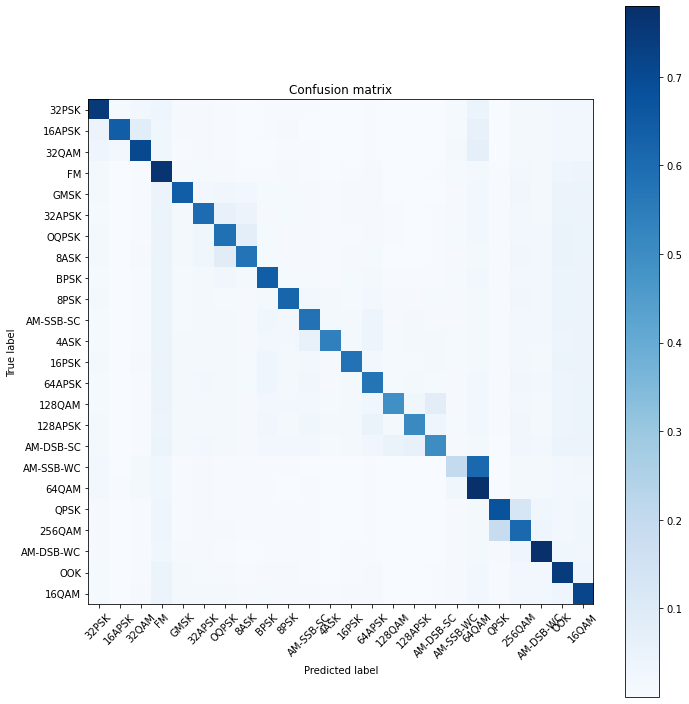

In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model_resnet.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

Overall Accuracy -20:  0.7062022984472323
Overall Accuracy -18:  0.6958828911253431
Overall Accuracy -16:  0.6800182898948332
Overall Accuracy -14:  0.7000183755972069
Overall Accuracy -12:  0.7118704714196261
Overall Accuracy -10:  0.7131408797013022
Overall Accuracy -8:  0.7245682249751334
Overall Accuracy -6:  0.7303317082496893
Overall Accuracy -4:  0.7290627227369921
Overall Accuracy -2:  0.7207435203769963


C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Overall Accuracy 0:  0.7150226244343891
Overall Accuracy 2:  0.729703494528768
Overall Accuracy 4:  0.7806192346332999
Overall Accuracy 6:  0.8631714733253478
Overall Accuracy 8:  0.9112794157424939
Overall Accuracy 10:  0.9399318630087861
Overall Accuracy 12:  0.9505992132467295
Overall Accuracy 14:  0.9485655927954694
Overall Accuracy 16:  0.9520711143695014
Overall Accuracy 18:  0.9508876272866541
Overall Accuracy 20:  0.9491071428571428
Overall Accuracy 22:  0.9561925365062196
Overall Accuracy 24:  0.955230575991387
Overall Accuracy 26:  0.9544656957360941
Overall Accuracy 28:  0.9519886615289219
Overall Accuracy 30:  0.9557119942969168


<Figure size 432x288 with 0 Axes>

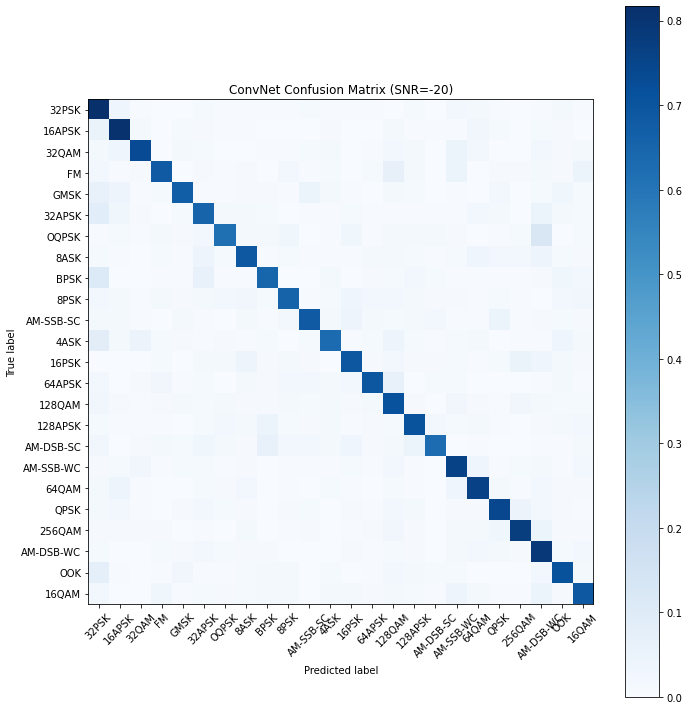

<Figure size 432x288 with 0 Axes>

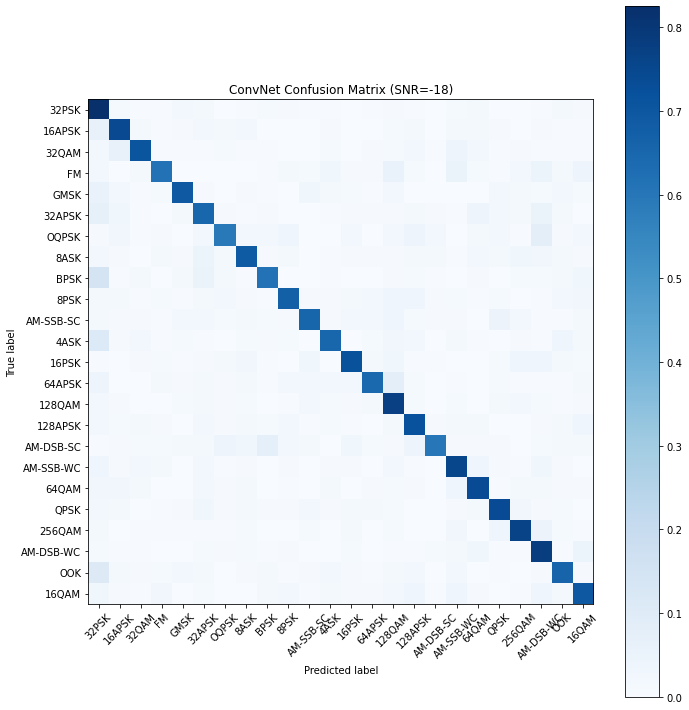

<Figure size 432x288 with 0 Axes>

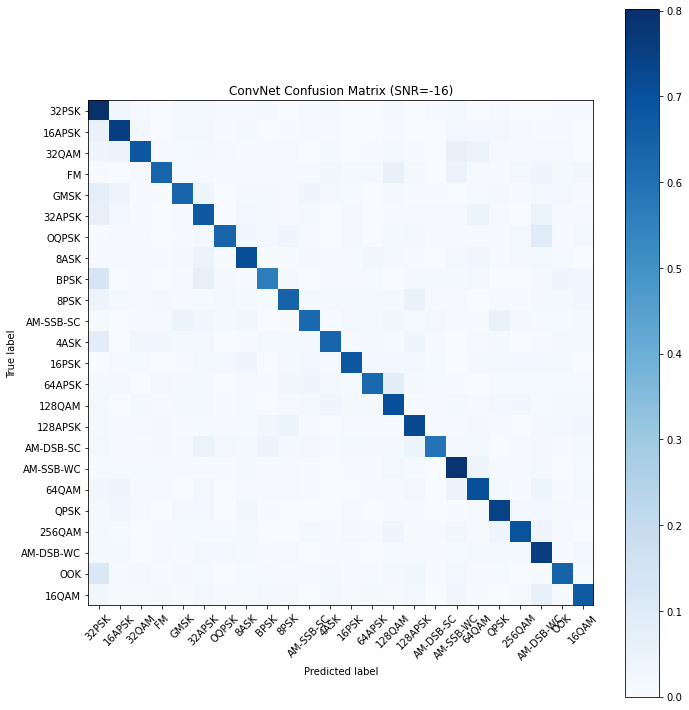

<Figure size 432x288 with 0 Axes>

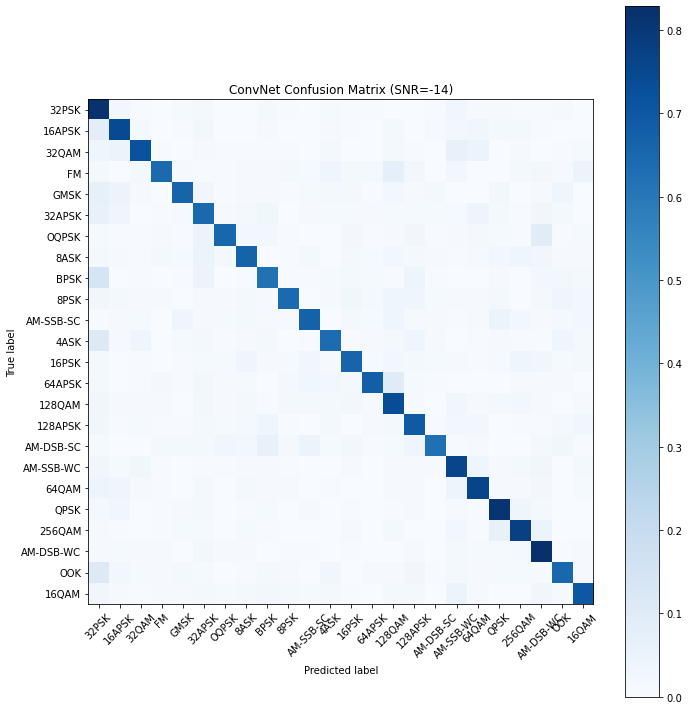

<Figure size 432x288 with 0 Axes>

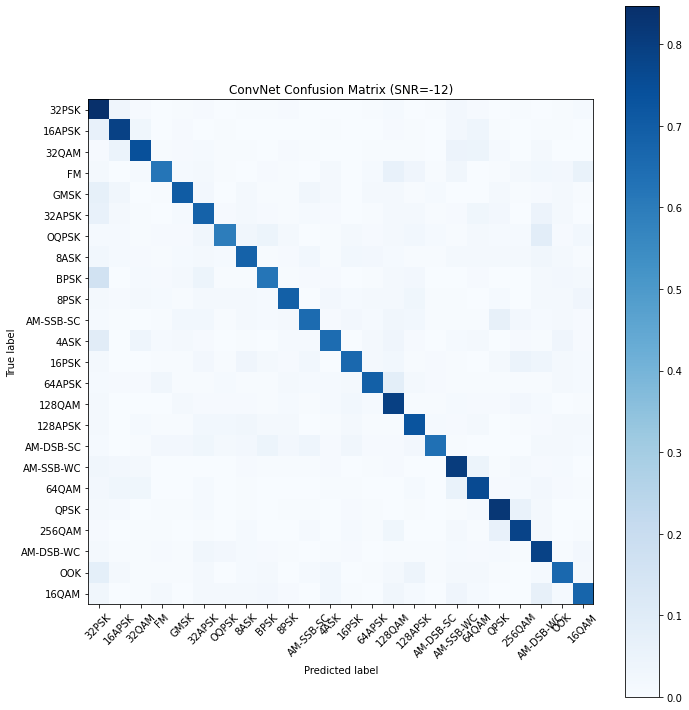

<Figure size 432x288 with 0 Axes>

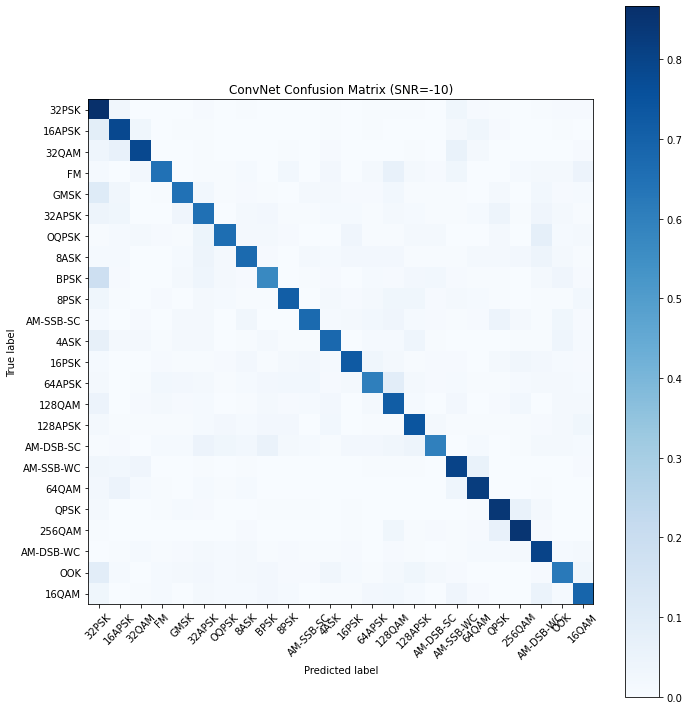

<Figure size 432x288 with 0 Axes>

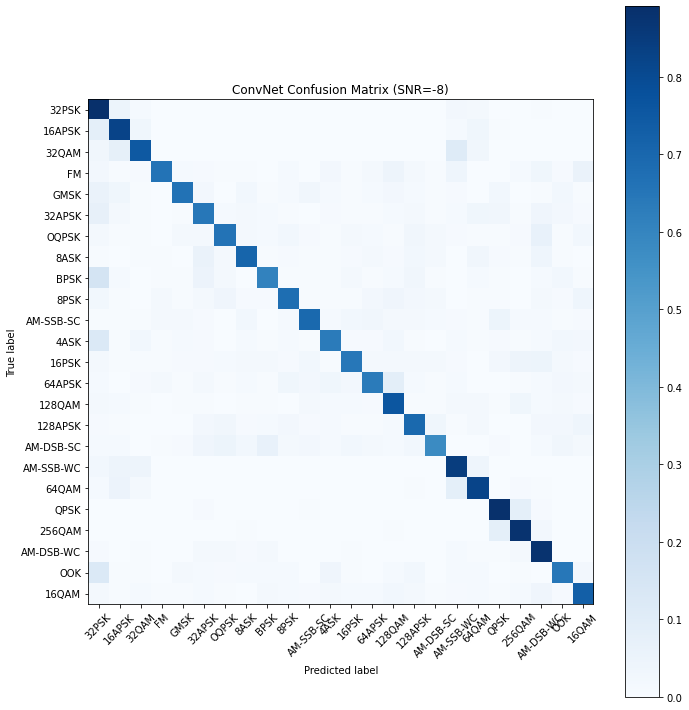

<Figure size 432x288 with 0 Axes>

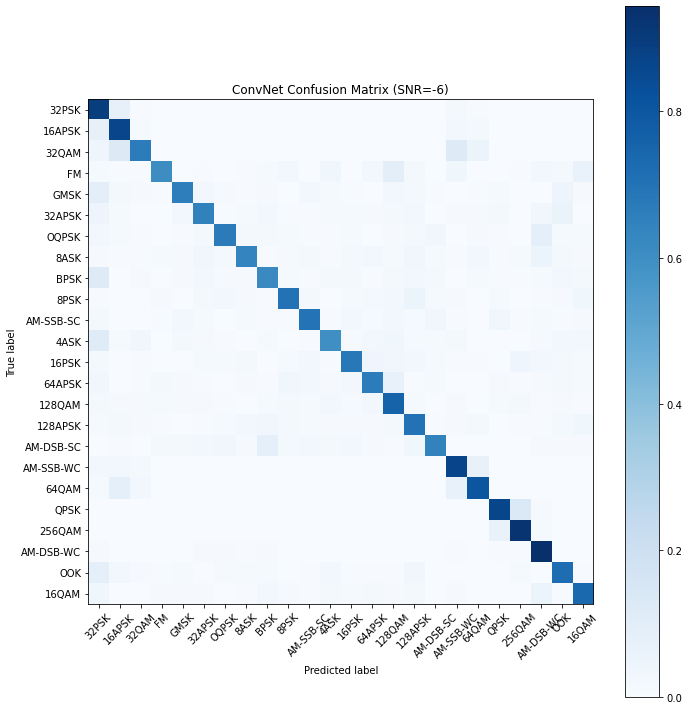

<Figure size 432x288 with 0 Axes>

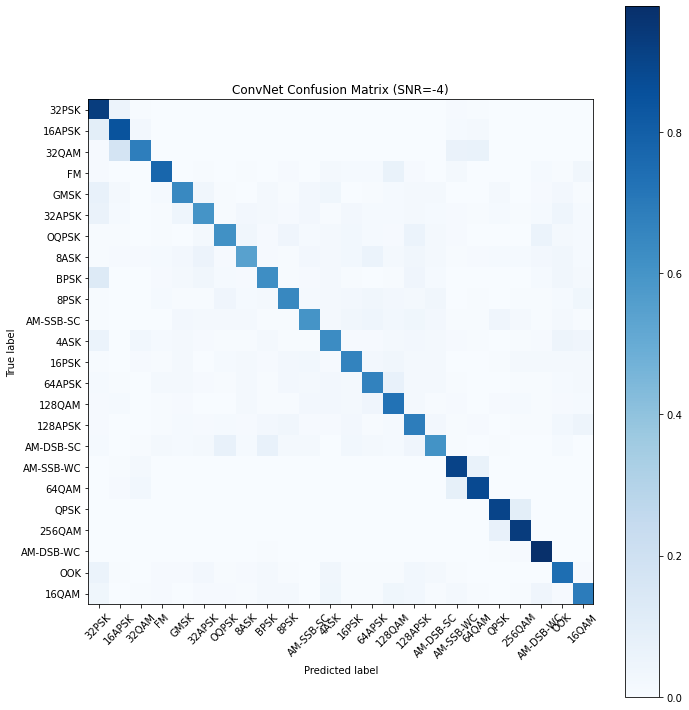

<Figure size 432x288 with 0 Axes>

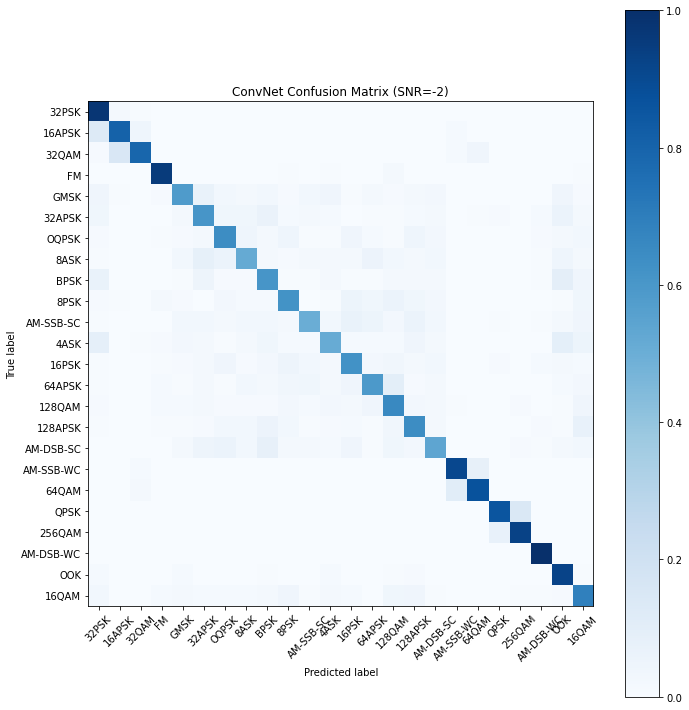

<Figure size 432x288 with 0 Axes>

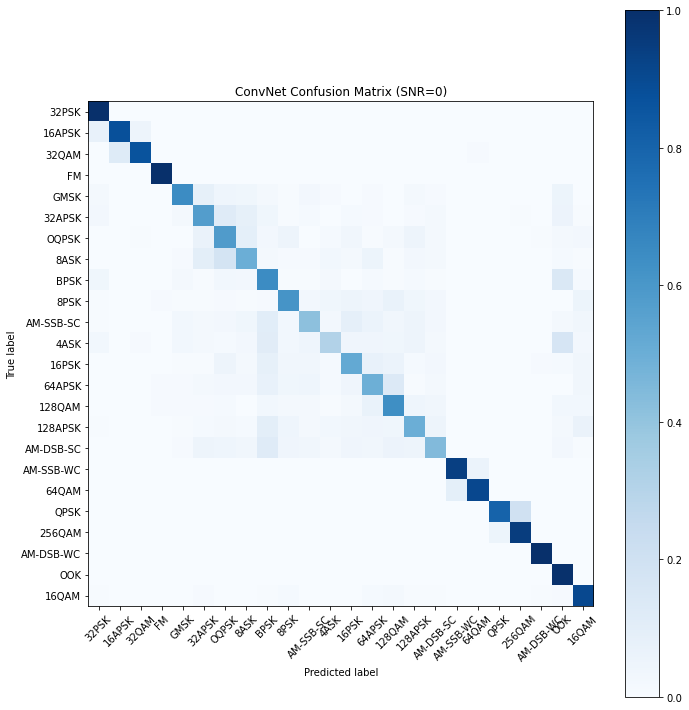

<Figure size 432x288 with 0 Axes>

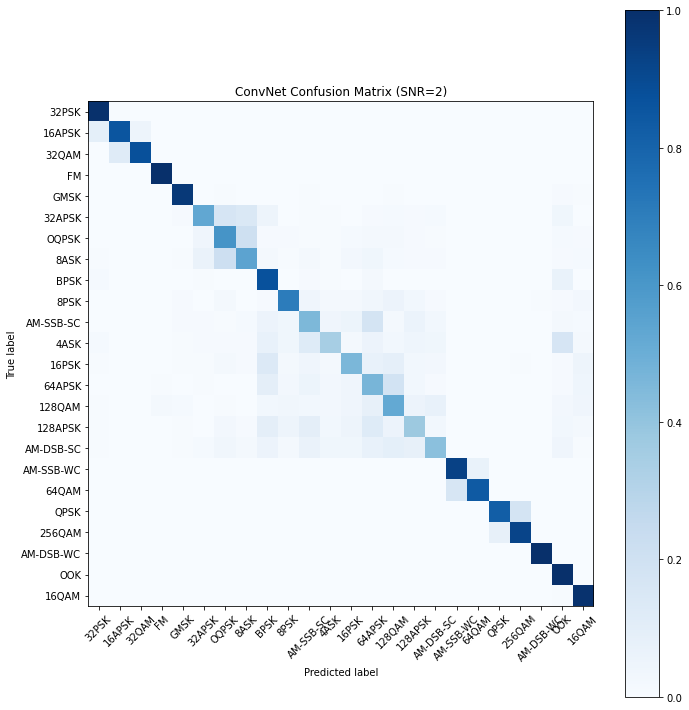

<Figure size 432x288 with 0 Axes>

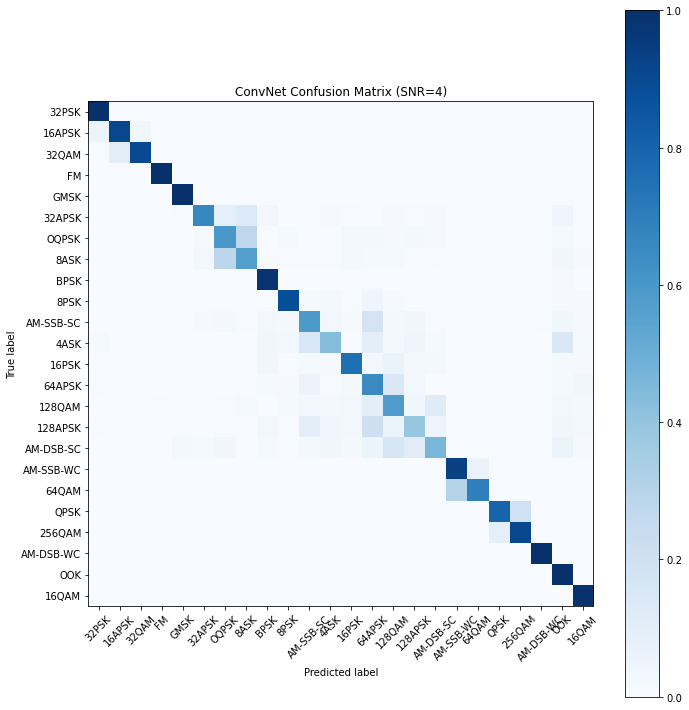

<Figure size 432x288 with 0 Axes>

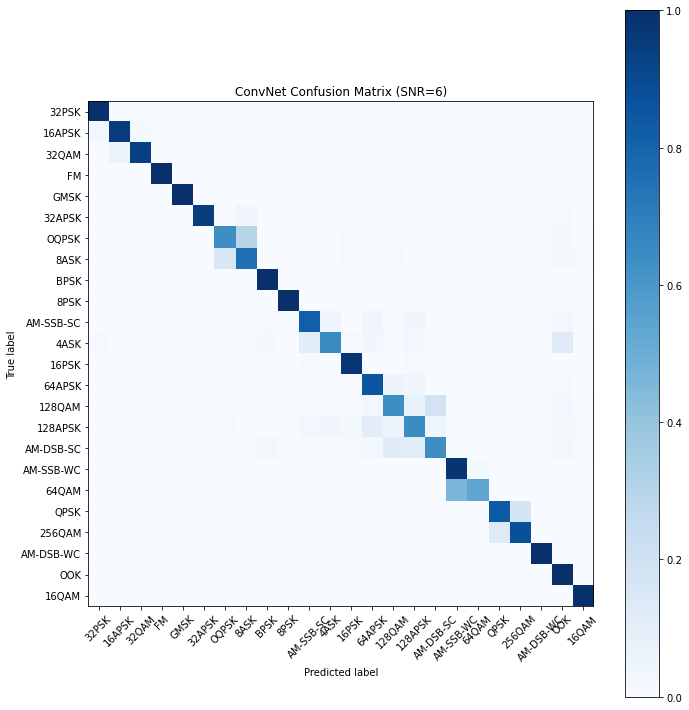

<Figure size 432x288 with 0 Axes>

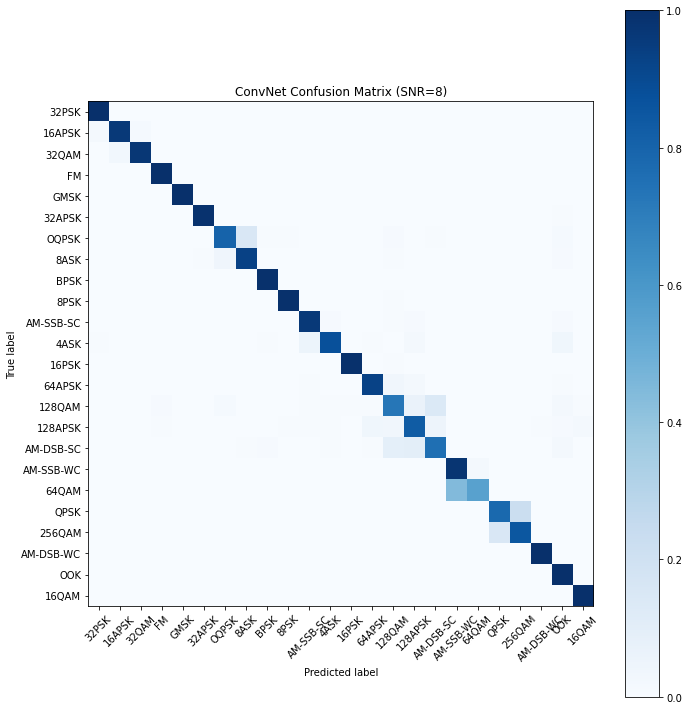

<Figure size 432x288 with 0 Axes>

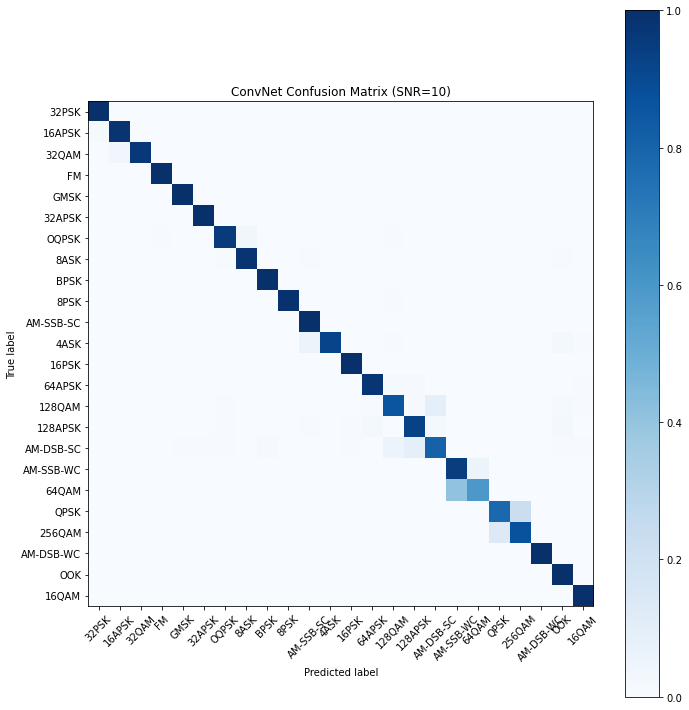

<Figure size 432x288 with 0 Axes>

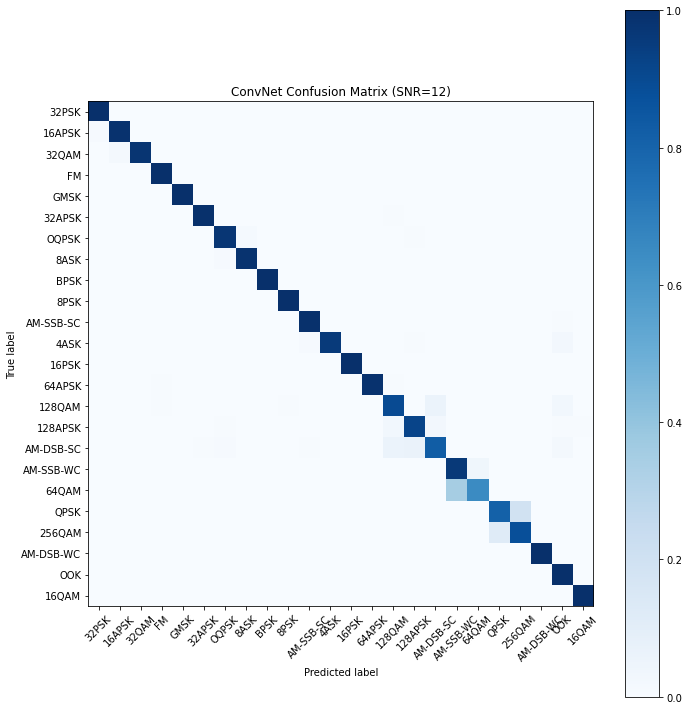

<Figure size 432x288 with 0 Axes>

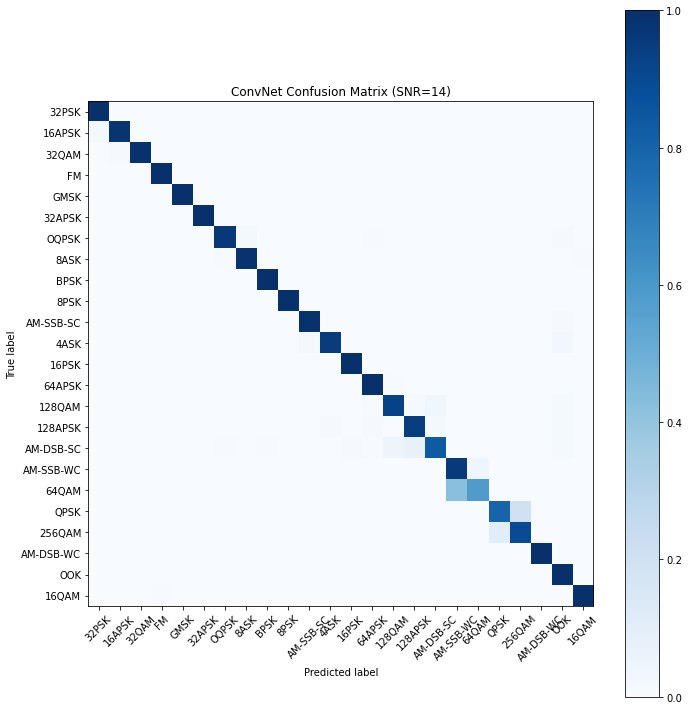

<Figure size 432x288 with 0 Axes>

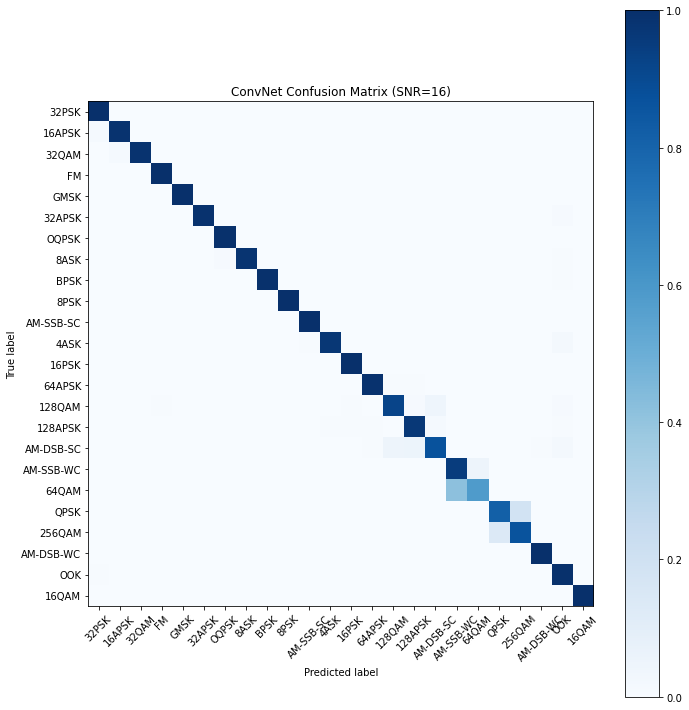

<Figure size 432x288 with 0 Axes>

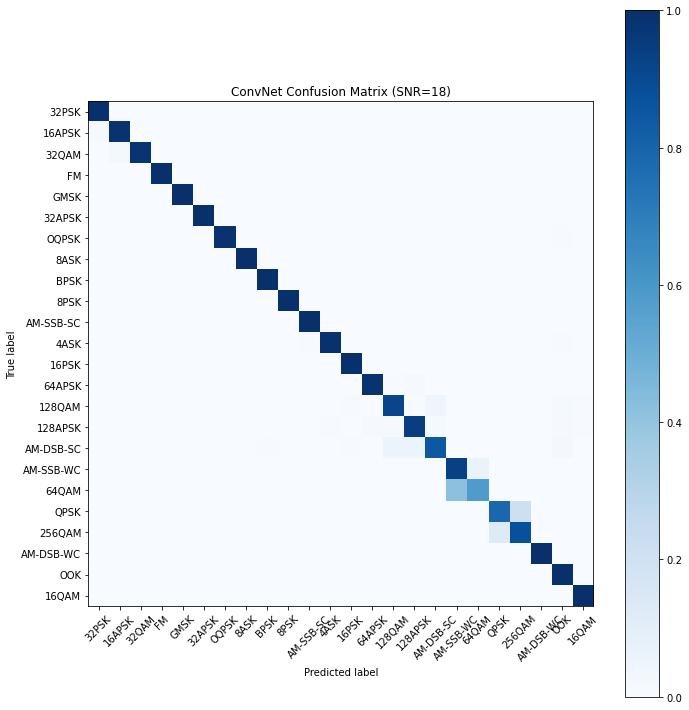

<Figure size 432x288 with 0 Axes>

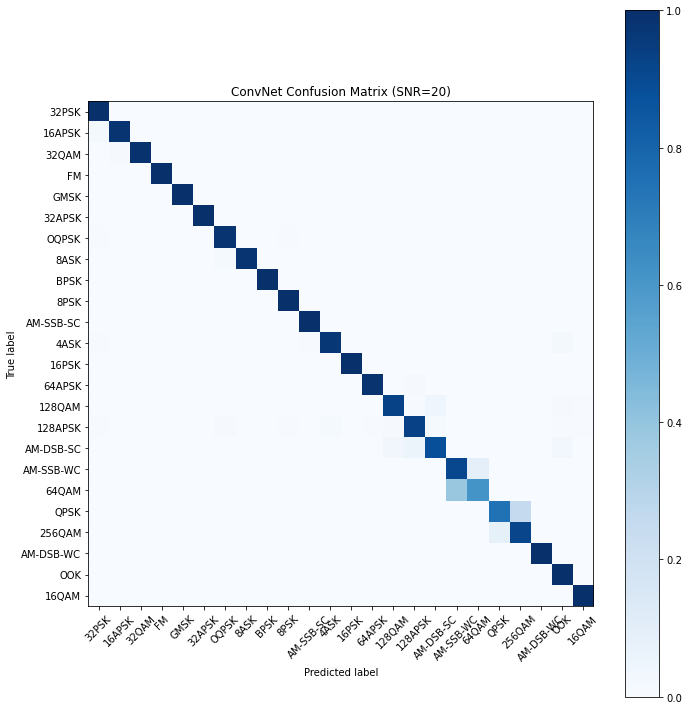

<Figure size 432x288 with 0 Axes>

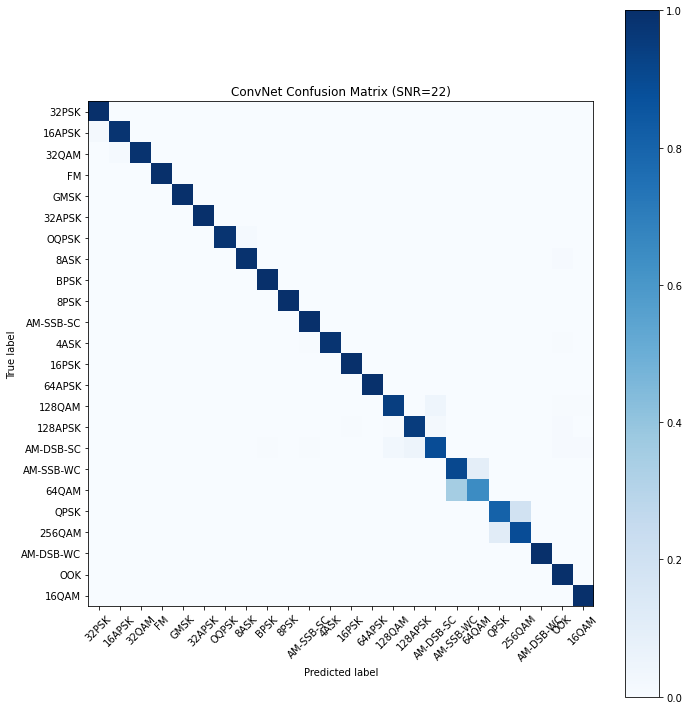

<Figure size 432x288 with 0 Axes>

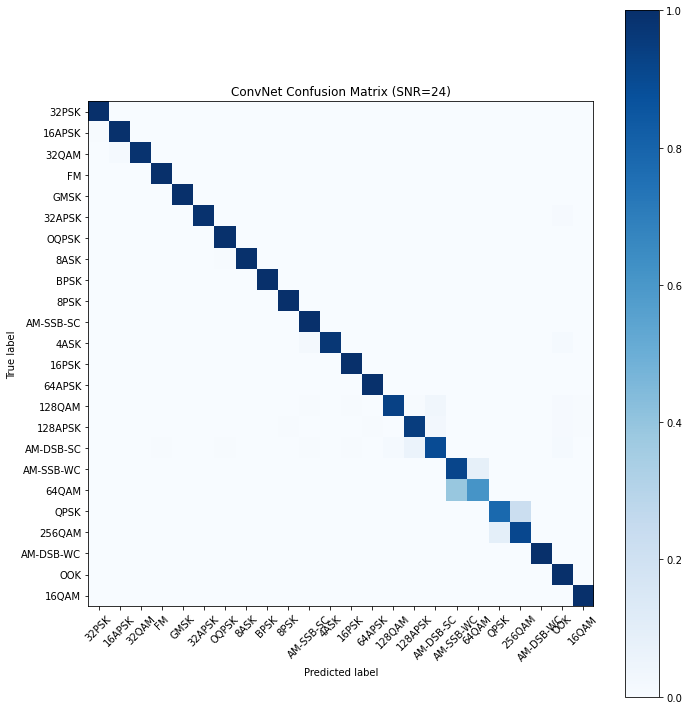

<Figure size 432x288 with 0 Axes>

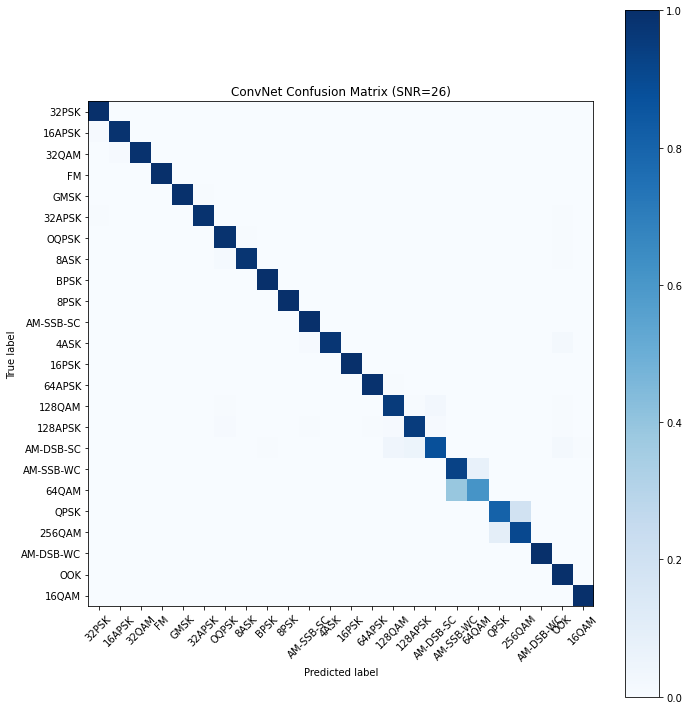

<Figure size 432x288 with 0 Axes>

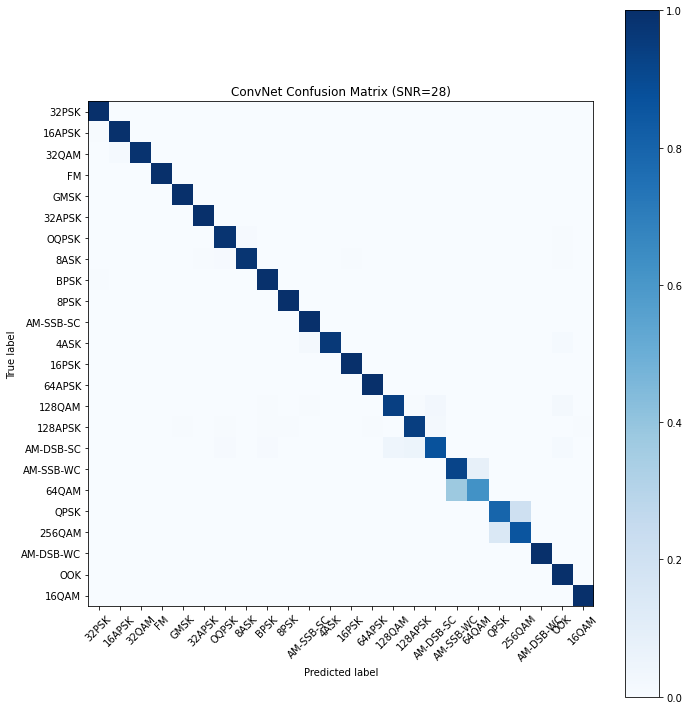

<Figure size 432x288 with 0 Axes>

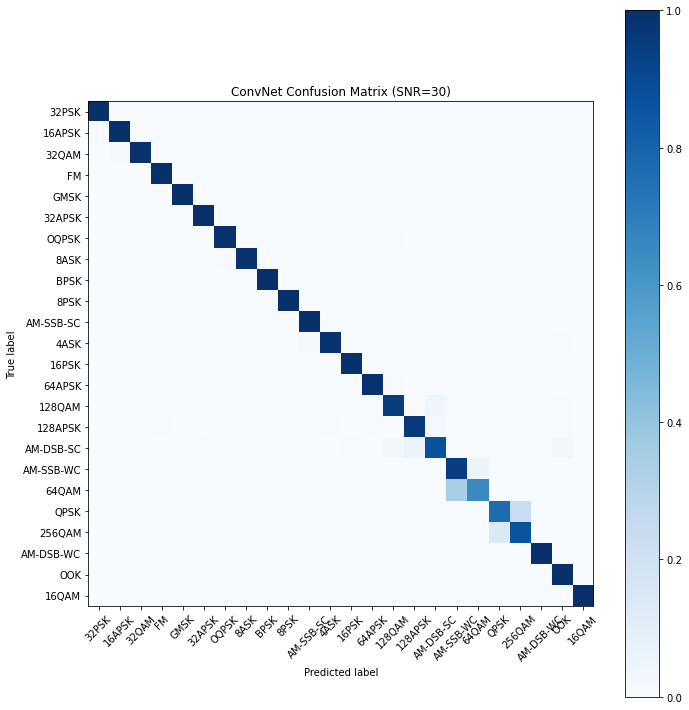

In [8]:
acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test_resnet = model_resnet.predict(X_test_snr)
    pre_Y_test_transformer = model_trafo.predict(X_test_snr)
    
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #Test data volume under this signal-to-noise ratio
        j = list(Y_test_snr[i,:]).index(1)   #Correct category index
        #Prediction category index
        if np.max(pre_Y_test_resnet[i,:]) > np.max(pre_Y_test_transformer[i,:]):
            k = int(np.argmax(pre_Y_test_resnet[i,:])) 
        else : k = int(np.argmax(pre_Y_test_transformer[i,:])) 
       
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

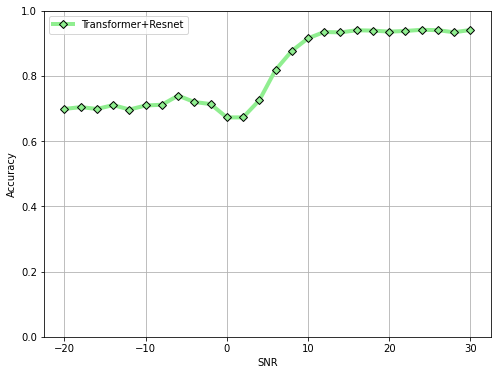

In [29]:
plt.figure(figsize=(8,6))
plt.plot(acc.keys(),acc.values(),linewidth=4,color='lightgreen', marker='D', markeredgecolor='black')
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.grid()
plt.legend(['Transformer+Resnet'],loc='upper left')
plt.show()

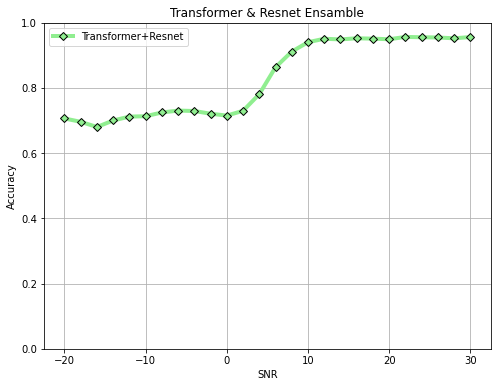

In [10]:
plt.figure(figsize=(8,6))
plt.plot(acc.keys(),acc.values(),linewidth=4,color='lightgreen', marker='D', markeredgecolor='black')
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title('Transformer & Resnet Ensamble')
plt.grid()
plt.legend(['Transformer+Resnet'],loc='upper left')
plt.show()